In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

import scipy.interpolate
import scipy.misc
import scipy.ndimage.interpolation

%matplotlib notebook

In [3]:
N_ang = 180           # N. of angles
N_rad = 256           # N. of radial samples
Imsize_X = 256
Imsize_Y = 256

phantom = np.fromfile("Data/SL_HC_256x256.raw",dtype=np.float32).reshape((Imsize_Y,Imsize_X))
sino = np.fromfile("Data/SL_HC_180x256_paralsino_theta_r.raw",dtype=np.float32).reshape((N_rad,N_ang))
sino = np.rot90(sino,2)

# Zero-padding. See function reference at https://numpy.org/doc/stable/reference/generated/numpy.pad.html
padded_sino = np.pad(sino, [(0,N_rad),(0,0)], mode='constant')

print("Shape of the phantom object: " + str(phantom.shape))
print("Shape of the sinogram object: " + str(sino.shape))
print("Shape of the padded sinogram object: " + str(padded_sino.shape))

Shape of the phantom object: (256, 256)
Shape of the sinogram object: (256, 180)
Shape of the padded sinogram object: (512, 180)


<IPython.core.display.Javascript object>


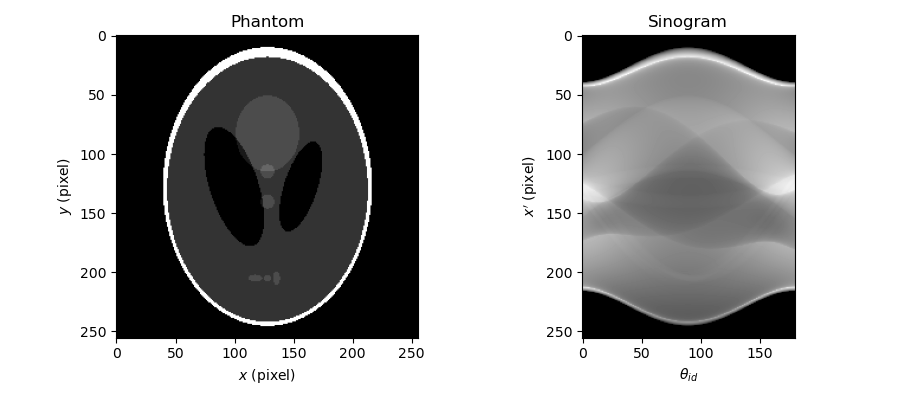

In [4]:
plt.figure(figsize=(9,4))
plt.gray()
plt.subplot(121)
plt.title("Phantom")
plt.xlabel(r"$x$ (pixel)")
plt.ylabel(r"$y$ (pixel)")
plt.imshow(phantom)

plt.subplot(122)
plt.title("Sinogram")
plt.xlabel(r"$\theta_{id}$")
plt.ylabel(r"$x^{\prime}$ (pixel)")
plt.imshow(sino)
plt.tight_layout()


In [5]:
sino_fft1d=np.fft.fftshift(
                np.fft.fft(
                    np.fft.ifftshift(
                        sino,
                        axes=0
                    ),
                axis=0
                ),
            axes=0
            )


In [6]:
phantom_fft2d=np.fft.fftshift(
                np.fft.fft2(
                    np.fft.ifftshift(
                        phantom
                    )
                )
            )

<IPython.core.display.Javascript object>


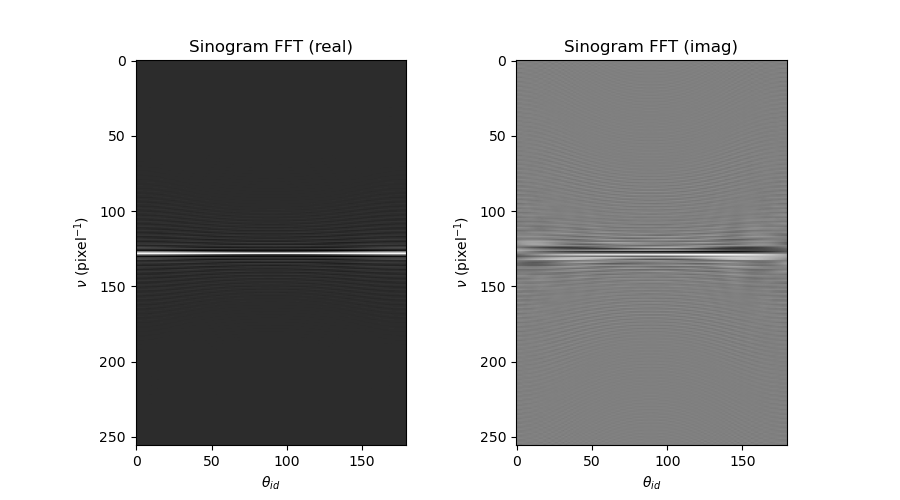

Text(0, 0.5, '$\\nu$ (pixel$^{-1}$)')

In [7]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.title("Sinogram FFT (real)")
plt.imshow(np.real(sino_fft1d))
plt.xlabel(r"$\theta_{id}$")
plt.ylabel(r"$\nu$ (pixel$^{-1}$)")

plt.subplot(122)
plt.title("Sinogram FFT (imag)")
plt.imshow(np.imag(sino_fft1d))
plt.xlabel(r"$\theta_{id}$")
plt.ylabel(r"$\nu$ (pixel$^{-1}$)")

In [8]:
# Coordinates of the Fourier transformed sinogram
th=np.array([np.pi*i/N_ang for i in range(N_ang)])
nu=np.arange(N_rad)-N_rad/2
th,nu=np.meshgrid(th,nu)
nu=nu.flatten()
th=th.flatten()

# Coordinates of 2D frequency space
xi_pol=(N_rad/2)+nu*np.cos(th)
upsilon_pol=(N_rad/2)+nu*np.sin(th)

<IPython.core.display.Javascript object>


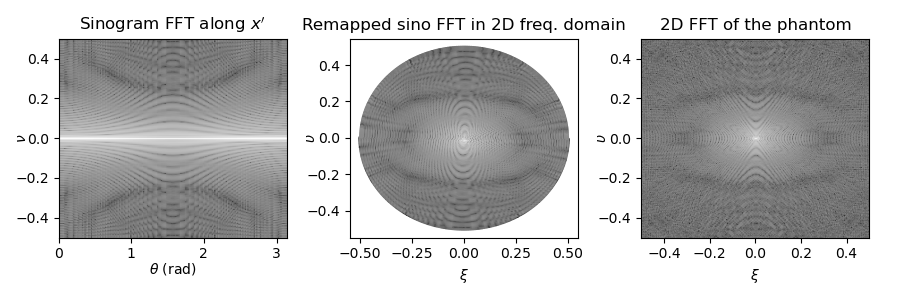

In [9]:
plt.gray()
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.title(r"Sinogram FFT along $x^{\prime}$")
plt.xlabel(r"$\theta$ (rad)", labelpad=0)
plt.ylabel(r"$\nu$", labelpad=-10)
plt.imshow(np.log(np.abs(sino_fft1d)), extent=[0,np.pi,-0.5,0.5], aspect="auto")

# Display the remapping of the 1D FFT of the sinogram on 2D frequency space
plt.subplot(132)
plt.title("Remapped sino FFT in 2D freq. domain")
plt.scatter(
    (xi_pol-Imsize_X/2)/Imsize_X,
    (upsilon_pol-Imsize_Y/2)/Imsize_Y,
        c=np.log(np.abs(sino_fft1d.flatten())),
    marker='.',
    edgecolor='none'
    )
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\upsilon$", labelpad=-8)

# Display the 2D FFT of phantom for comparison
plt.subplot(133)
plt.title("2D FFT of the phantom")
plt.imshow(np.log(np.abs(phantom_fft2d)), extent=[-0.5,0.5,-0.5,0.5], aspect="auto")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\upsilon$", labelpad=-8)

plt.tight_layout()

In [10]:
xi_cart,upsilon_cart=np.meshgrid(np.arange(N_rad),np.arange(N_rad))
xi_cart=xi_cart.flatten()
upsilon_cart=upsilon_cart.flatten()

# Interpolate the 2D Fourier space grid from the transformed sinogram
remapped_fft2d=scipy.interpolate.griddata(
        (xi_pol,upsilon_pol),
        sino_fft1d.flatten(),
        (xi_cart,upsilon_cart),
        method='cubic',
        fill_value=0.0
    ).reshape((N_rad,N_rad))

In [11]:
recon=np.real(
    np.fft.fftshift(
        np.fft.ifft2(
            np.fft.ifftshift(remapped_fft2d)
            )
        )
    )


<IPython.core.display.Javascript object>


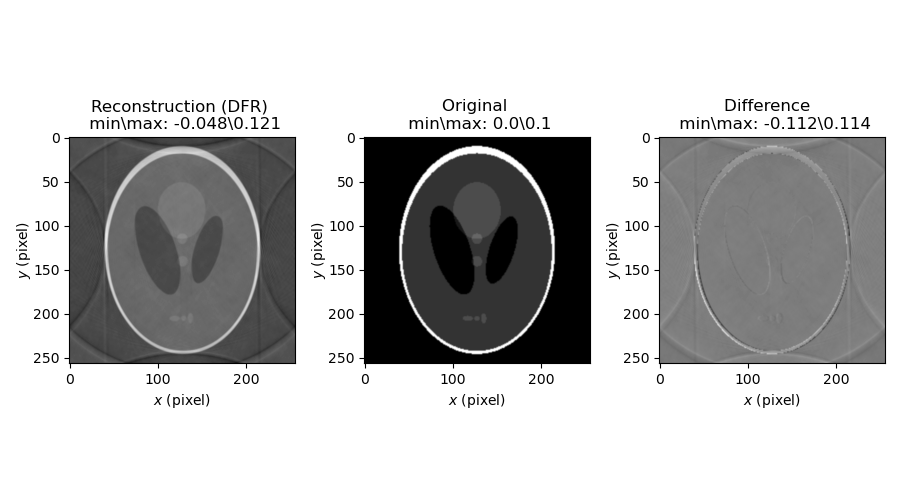

In [12]:
# Compute the error image (original - recon)
difference=np.subtract(phantom,recon)

# Display the reconstructed image and difference with original
plt.figure(figsize=(9,5))
plt.subplot(131)
plt.title("Reconstruction (DFR) \n min\max: " + str(np.around(np.min(recon),3)) + "\\" + str(np.around(np.max(recon),3)))
plt.imshow(recon, interpolation='bicubic')
plt.xlabel(r"$x$ (pixel)")
plt.ylabel(r"$y$ (pixel)", labelpad = 0)
plt.subplot(132)
plt.title("Original \n min\max: " + str(np.around(np.min(phantom),3)) + "\\" + str(np.around(np.max(phantom),3)))
plt.imshow(phantom, interpolation='bicubic')
plt.xlabel(r"$x$ (pixel)")
plt.ylabel(r"$y$ (pixel)", labelpad = 0)
plt.subplot(133)
plt.title("Difference  \n min\max: " + str(np.around(np.min(difference),3)) + "\\" + str(np.around(np.max(difference),3)))
plt.imshow(difference, interpolation='bicubic')
plt.xlabel(r"$x$ (pixel)")
plt.ylabel(r"$y$ (pixel)", labelpad = 0)
plt.tight_layout()